# Team Members
 ## 1. Mitesh Sanjay Jalan (SBU ID: 115222506)
 ## 2. Smit Kamleshbhai Kumbhani (SBU ID: 114964474)
 ## 3. Pritish Thombare (SBU ID: 115382224) 

This code is divided into following subtasks:
1) First we setup the training parameters for the model.
2) We also setup the LoRa parameters for the model.
3) We read the train set of the QA dataset for instruction tuning and tokenize it using the respective model's tokeinizer.
4) We execute the training loop and record the training loss.
5) We finally plot the training loss against the number of iterations.

## Data frameworks

* [1. Syntax] - We are using the tokenizer of TinyLlama and Phi-2 to tokenize the input.
* [3. Transformers] - We have used Auto-regressive (Generative) language models for the QA task. We are also Instruction Tuning the model on the QA dataset.

## Envrionment Details
* Ubuntu 18 LTS
* CUDA 12.1
* Nvidia Tesla V-100 16 GB

In [5]:
import transformers
from IPython.display import clear_output
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
import matplotlib.pyplot as plt

from peft import LoraConfig, PeftModel
from trl import SFTTrainer
import pandas as pd
from datasets import Dataset
import datasets
from transformers import TrainingArguments

In [6]:
def set_training_arguments(output_dir="./results", num_train_epochs=5, per_device_train_batch_size=2, gradient_accumulation_steps=1, optim="paged_adamw_32bit", save_steps=1, logging_steps=1, learning_rate=2e-4, weight_decay=0.001, fp16=False, bf16=False, max_grad_norm=0.3, max_steps=-1, warmup_ratio=0.03, group_by_length=True, lr_scheduler_type="constant", report_to="tensorboard"):
    training_params = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        optim=optim,
        save_steps=save_steps,
        logging_steps=logging_steps,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        fp16=fp16,
        bf16=bf16,
        max_grad_norm=max_grad_norm,
        max_steps=max_steps,
        warmup_ratio=warmup_ratio,
        group_by_length=group_by_length,
        lr_scheduler_type=lr_scheduler_type,
        report_to=report_to
    )
    return training_params

def set_lora_configuration(lora_alpha=16, lora_dropout=0.1, r=64, bias="none", task_type="CAUSAL_LM"): 
    peft_args = LoraConfig(lora_alpha=lora_alpha, lora_dropout=lora_dropout, r=r, bias=bias, task_type=task_type)
    return peft_args

def plotloss(df):
    loss_values = df["loss"]
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values, label='Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def Train(Huggingface_Model_rope, dataset_hf, local_model_path_untrained = None, local_model_path_destination=None,training_params = None,peft_args=None):
        base_model = Huggingface_Model_rope
        compute_dtype = getattr(torch, "float16")
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=compute_dtype,
            bnb_4bit_use_double_quant=False,
        )
                
        if os.path.exists(local_model_path_untrained):
            model = AutoModelForCausalLM.from_pretrained(local_model_path_untrained)
            tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
            if base_model=="microsoft/phi-2":
                tokenizer.padding_side='right'
                tokenizer.pad_token=tokenizer.eos_token
            print("Model loaded from pickle.")
        else:
            model = AutoModelForCausalLM.from_pretrained(
                base_model,
                quantization_config=quant_config,
                device_map={"": 0}
            )

            model.config.use_cache = False
            model.config.pretraining_tp = 1
            
            tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
            tokenizer.pad_token = tokenizer.eos_token
            tokenizer.padding_side = "right"
            model.save_pretrained(local_model_path_untrained)
        
        def tokenize_function(examples):
            return tokenizer(examples['text'], add_special_tokens=True, padding=True, truncation=True, return_tensors="pt")

        tokenized_dataset = dataset_hf.map(tokenize_function, batched=True)

        trainer = SFTTrainer(
            model=model,
            train_dataset=tokenized_dataset,
            peft_config=peft_args,
            dataset_text_field="text",
            max_seq_length=512,
            tokenizer=tokenizer,
            args=training_params,
            packing=False,
        )
               
        trainer.train()
        
        # Access the state of the trainer to get the loss
        loss = pd.DataFrame(trainer.state.log_history)
        plotloss(loss)
        
        trainer.model.save_pretrained(local_model_path_destination)
        trainer.tokenizer.save_pretrained(local_model_path_destination)


In [7]:
if not os.path.exists('./models'):
    os.makedirs('models')

Train TinyLLama2

In [8]:
tiny_llama_training_para=set_training_arguments()
tiny_llama_lora_para=set_lora_configuration()
hp_dataset_hf = pd.read_csv('./Ragwards_dataset_repo/harry-potter-trivia-ai/train.csv')


data_dict = {'text': hp_dataset_hf['text'].to_list()}
dataset_hf= Dataset.from_dict(data_dict)

Map: 100%|██████████| 10/10 [00:00<00:00, 989.57 examples/s]
/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
1,3.641700
2,3.280600
3,3.510100
4,3.095800
5,3.302700
6,3.096900
7,3.029000
8,3.102000
9,2.748200
10,3.014800


/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/paral

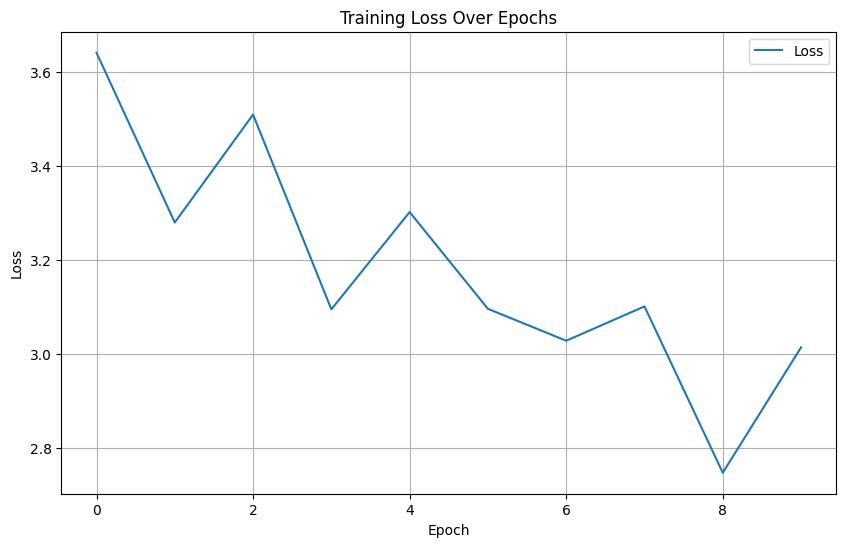

In [9]:
Train("TinyLlama/TinyLlama-1.1B-Chat-v1.0",dataset_hf,'./models/untrained_tiny_llama/','./models/trained_tiny_llama_r100_epoch_5/',tiny_llama_training_para,tiny_llama_lora_para)

Phi-2

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 10/10 [00:00<00:00, 829.49 examples/s]
/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
1,0.380500
2,0.353000
3,0.329300
4,0.304500
5,0.273900


/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mitesh/miniconda3/envs/llmfinetuned/lib/python3.11/site-packages/torch/nn/paral

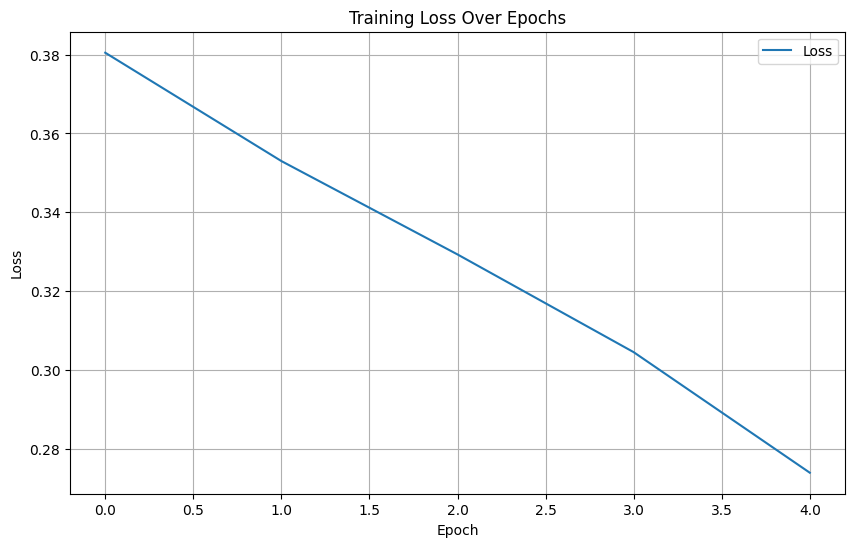

In [10]:
phi2_training_para=set_training_arguments(per_device_train_batch_size=4,gradient_accumulation_steps=10)
phi2_lora_para=set_lora_configuration()
hp_dataset_hf = pd.read_csv('./Ragwards_dataset_repo/harry-potter-trivia-ai/train.csv')
hp_dataset_hf['text'] = '### Human: ' + hp_dataset_hf['question'] + ' ### Assistant: ' + hp_dataset_hf['answer']
data_dict = {'text': hp_dataset_hf['text'].to_list()}
dataset_hf= Dataset.from_dict(data_dict)
Train("microsoft/phi-2",dataset_hf,'./models/untrained_phi2/','./models/trained_phi2/',phi2_training_para,phi2_lora_para)

## References

* https://www.datacamp.com/tutorial/fine-tuning-llama-2?irclickid=xc0ViaQ8xxyPWMp0gwwhE127UkHTF91m2Si00w0&irgwc=1&utm_medium=affiliate&utm_source=impact&utm_campaign=000000_1-2003851_2-mix_3-all_4-na_5-na_6-na_7-mp_8-affl-ip_9-na_10-bau_11-Bing%20Rebates%20by%20Microsoft&utm_content=BANNER&utm_term=EdgeBingFlow
* https://github.com/VenomZein/Chatbot-for-Q-A/blob/main/Q_A_chatbot.ipynb
* https://huggingface.co/datasets/saracandu/harry-potter-trivia-ai